In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ritvik1909/document-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/document-classification-dataset


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import string
import nltk
import pathlib
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC

In [3]:
train = pathlib.Path(os.path.join(path))

In [4]:
train

PosixPath('/kaggle/input/document-classification-dataset')

In [5]:
def get_images_labels(images, label):
  arr = []
  labels = []
  for i in images:
    img = cv2.imread(os.path.join(i))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (120, 120))
    img1 = img[0:30, 0:120]/255
    img2 = img[30:90, 0:60]/255
    img3 = img[30:90, 60:120]/255
    img4 = img[90:120, 0:120]/255
    img = np.asarray([cv2.resize(img1, (48, 48)),
                      cv2.resize(img2, (48, 48)),
                      cv2.resize(img3, (48, 48)),
                      cv2.resize(img4, (48, 48))])
    img_mean = np.mean(img)
    img = img - img_mean
    img = img / np.std(img)
    arr.append(img)
    labels.append(label)
  return [arr, labels]

In [6]:
# class_folders = os.listdir(path)
# class_to_label = {class_folder: index for index, class_folder in enumerate(class_folders)}

# images = []
# labels = []

# for class_folder in class_folders:
#     class_path = os.path.join(path, class_folder)
#     for image_filename in os.listdir(class_path):
#         image_path = os.path.join(class_path, image_filename)
#         images.append(image_path)
#         labels.append(class_to_label[class_folder])

# d = {label: labels.count(label) for label in labels}
# d

In [7]:
! ls {train}

email  resume  scientific_publication


In [8]:
[resume, Y_resume] = get_images_labels(list(train.glob("resume/*.*")), 0)
[email, Y_email] = get_images_labels(list(train.glob("email/*.*")), 1)
[scientific_publication, Y_scientific_publication] = get_images_labels(list(train.glob("scientific_publication/*.*")), 2)

In [9]:
images = resume + email + scientific_publication
labels = Y_resume + Y_email + Y_scientific_publication

In [10]:
images = np.asarray(images)
labels = np.asarray(labels)

In [11]:
# setup
seed = 123
crop = False
batch_size = 32
img_height = 400
img_width = 400
validation_split = 0.2

# train set
train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    crop_to_aspect_ratio=crop,
    shuffle=True
)

# validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
    path, validation_split=validation_split, subset="validation", seed=seed,
    image_size=(img_height, img_width), batch_size=batch_size, crop_to_aspect_ratio=crop, shuffle=True
)

Found 165 files belonging to 3 classes.
Using 132 files for training.
Found 165 files belonging to 3 classes.
Using 33 files for validation.


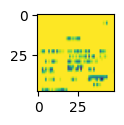

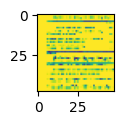

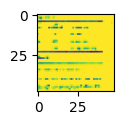

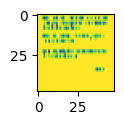

In [12]:
for i in range(4):
  plt.figure(figsize = (1, 1))
  plt.imshow(images[4][i])
  plt.grid(False)
  plt.show()

In [13]:
labels = to_categorical(labels)

In [14]:
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)

(32, 400, 400, 3) (32,)


In [15]:
import keras
from keras import layers

In [16]:
# data augmentation
data_augmentation = keras.Sequential([
  layers.RandomZoom(height_factor=0.05, width_factor=0.05),
  layers.RandomTranslation(height_factor=0.05, width_factor=0.05) # random shifts
])

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(400, 400, 3)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax'),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 398, 398, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 199, 199, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 197, 197, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 98, 98, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 614656)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    78,676,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,695,875 (300.20 MB)

 Trainable params: 78,695,875 (300.20 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
model.compile(optimizer='adam',
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      metrics=['accuracy']
    )

In [20]:
from keras.callbacks import TensorBoard, EarlyStopping
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 16, mode = 'min', restore_best_weights = True)

In [21]:
# train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [22]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [23]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    batch_size=batch_size,
    callbacks=[earlyStopping]
)

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.3981 - loss: 14391.6182 - val_accuracy: 0.3636 - val_loss: 4776.1328
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.3162 - loss: 4516.4893 - val_accuracy: 0.1818 - val_loss: 1146.1638
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.3987 - loss: 642.9592 - val_accuracy: 0.5455 - val_loss: 9.0750
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.6389 - loss: 12.2359 - val_accuracy: 0.5455 - val_loss: 7.4609
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step - accuracy: 0.9457 - loss: 0.8169 - val_accuracy: 0.6667 - val_loss: 1.6007
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 1.0000 - loss: 0.0193 - val_accuracy: 0.7273 - val_loss: 2.6279
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9975 - loss: 0.0074 - val_accuracy: 0.6970 - val_loss: 9.7543
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9164 - loss: 2.8202 - val_accura

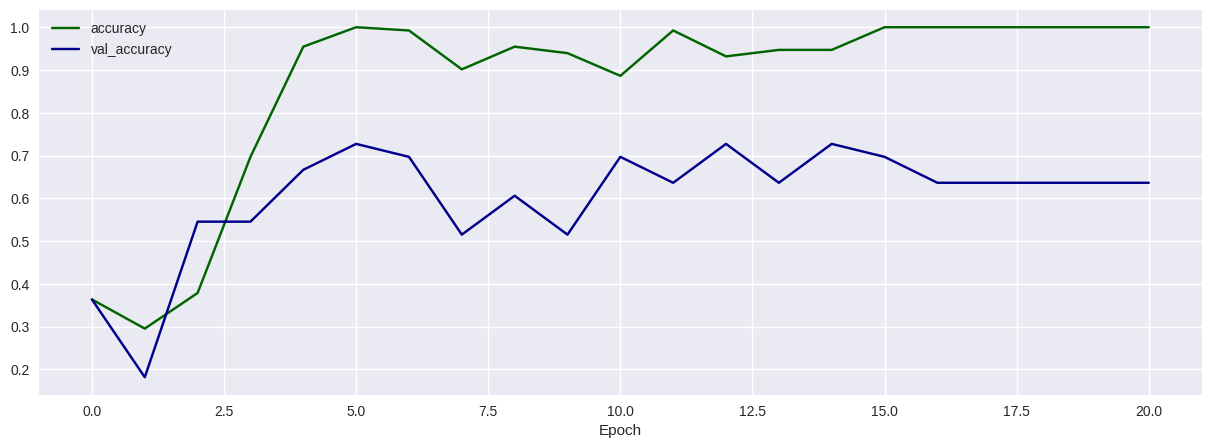

In [24]:
import matplotlib as mpl
mpl.style.use('seaborn-v0_8')
plt.figure(figsize = (15, 5))
plt.plot(history.history['accuracy'], "darkgreen", label= "accuracy")
plt.plot(history.history['val_accuracy'], "darkblue", label= "val_accuracy")
plt.xlabel('Epoch')
plt.legend()

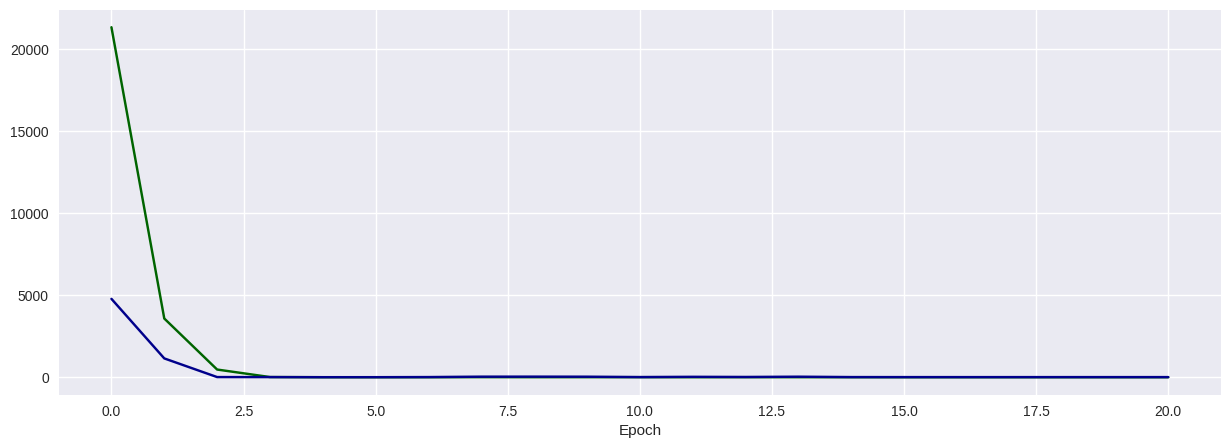

In [25]:
mpl.style.use('seaborn-v0_8')
plt.figure(figsize = (15, 5))
plt.plot(history.history['loss'], "darkgreen", label= "accuracy")
plt.plot(history.history['val_loss'], "darkblue", label= "accuracy")
plt.xlabel('Epoch')
plt.show()

In [26]:
model.evaluate(images, labels, batch_size=32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0444


[0.04435444623231888, 1.0]

In [27]:
y_pred = model.predict(images, batch_size=32, verbose= 1)
y_pred = np.argmax(y_pred, axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


In [28]:
y_test = labels.numpy()
y_test

array([0, 2, 0, 2, 1, 2, 0, 2, 1, 0, 2, 0, 2, 1, 0, 2, 0, 1, 2, 1, 0, 0,
       0, 2, 2, 1, 0, 0, 2, 1, 0, 1], dtype=int32)

In [29]:
y_pred

array([0, 2, 0, 2, 1, 2, 0, 2, 1, 0, 2, 0, 2, 1, 0, 2, 0, 1, 2, 1, 0, 0,
       0, 2, 2, 1, 0, 0, 2, 1, 0, 1])

In [30]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_score(y_test, y_pred)

1.0

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        11

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



In [32]:
classes = list(range(3))
res = tf.math.confusion_matrix(y_pred,y_test).numpy()
cm = pd.DataFrame(res,
                     index = classes,
                     columns = classes)
cm

,0,1,2
0,13,0,0
1,0,8,0
2,0,0,11


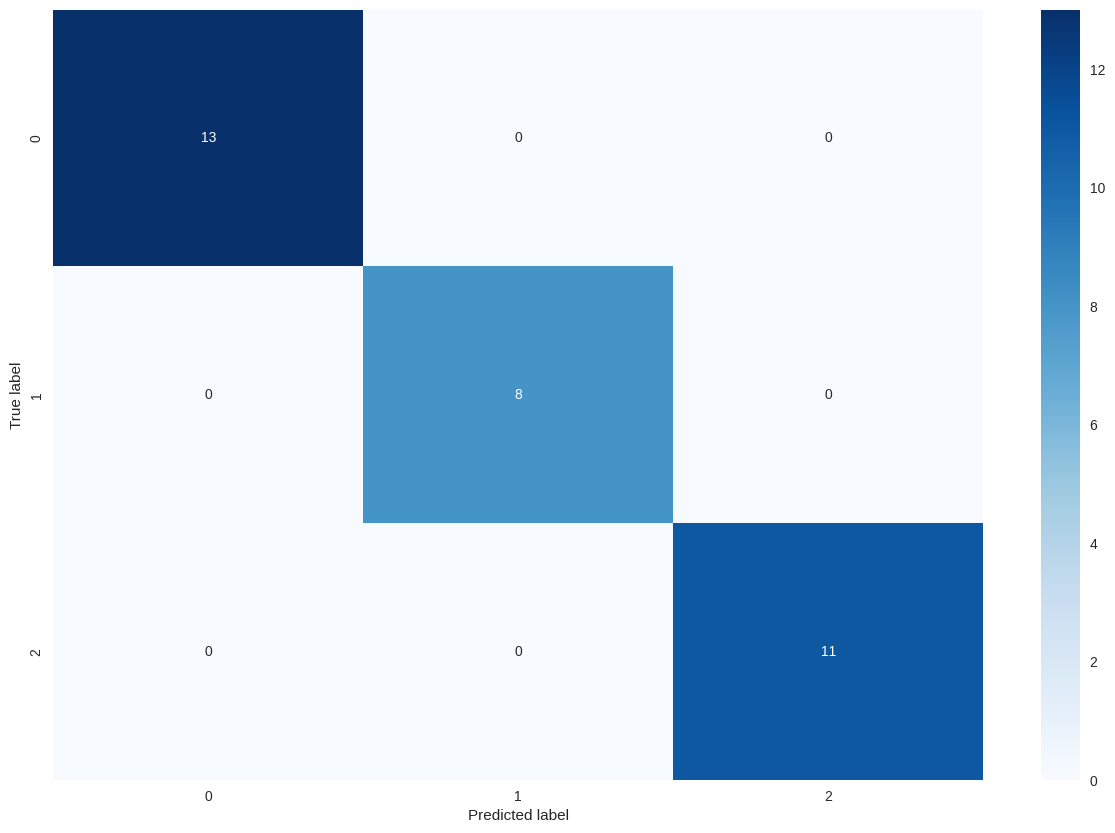

In [33]:
import seaborn as sns
figure = plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [35]:
# prompt: save keras model in a way that it can be reused

model.save("cnn_doc_classifier.keras")

In [36]:
# prompt: load saved keras model and create function that takes loaded model and image and provide output class

loaded_model = tf.keras.models.load_model("cnn_doc_classifier.keras")

def predict_image_class(model, image_path):
  img = tf.keras.utils.load_img(
      image_path, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  class_names = ['email', 'resume', 'scientific_publication'] # Assuming this order based on dataset loading
  predicted_class = class_names[np.argmax(score)]
  confidence = 100 * np.max(score)

  print(f"This image most likely belongs to {predicted_class} with a {confidence:.2f}% confidence.")
  return predicted_class, confidence

In [37]:
# prompt: download the saved keras model

from google.colab import files
files.download('cnn_doc_classifier.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
model_size_bytes = os.path.getsize("cnn_doc_classifier.keras")
print(f"Size of cnn_doc_classifier.keras: {model_size_bytes} bytes")
print(f"Size of cnn_doc_classifier.keras: {model_size_bytes / (1024 * 1024):.2f} MB")

Size of cnn_doc_classifier.keras: 944388082 bytes
Size of cnn_doc_classifier.keras: 900.64 MB


### Data Augmentation

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
class_names = ['email', 'resume', 'scientific_publication']

In [ ]:
# visualizing the augmented data
plt.figure(figsize=(10, 7))
for images, labels in train_ds.take(1):
  for i in range(6):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")